In [1]:
import os

import keras

print("Keras = {}".format(keras.__version__))
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import seaborn as sns
import pandas as pd


# Print gpus
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

# model_dir = './models/'
model_file = 'resnet50_brain_mri.keras'

Keras = 2.15.0
Num GPUs Available:  1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! unzip -o /content/drive/MyDrive/dataset_19.zip
! unzip -o /content/drive/MyDrive/Brain_MRI.zip

! pwd

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/Tr-gl_0732.jpg  
  inflating: Training/glioma/

# Load the data

In [4]:
# Data Directories
dir = "dataset_19/"
validation_dir = "Testing"

# Data distribution

In [5]:
data_distribution_count = pd.Series(
    {curr_index: len(os.listdir(os.path.join(dir, curr_index))) for curr_index in os.listdir(dir)})

data_distribution_count

pituitary     120
notumor       120
meningioma    120
glioma        120
dtype: int64

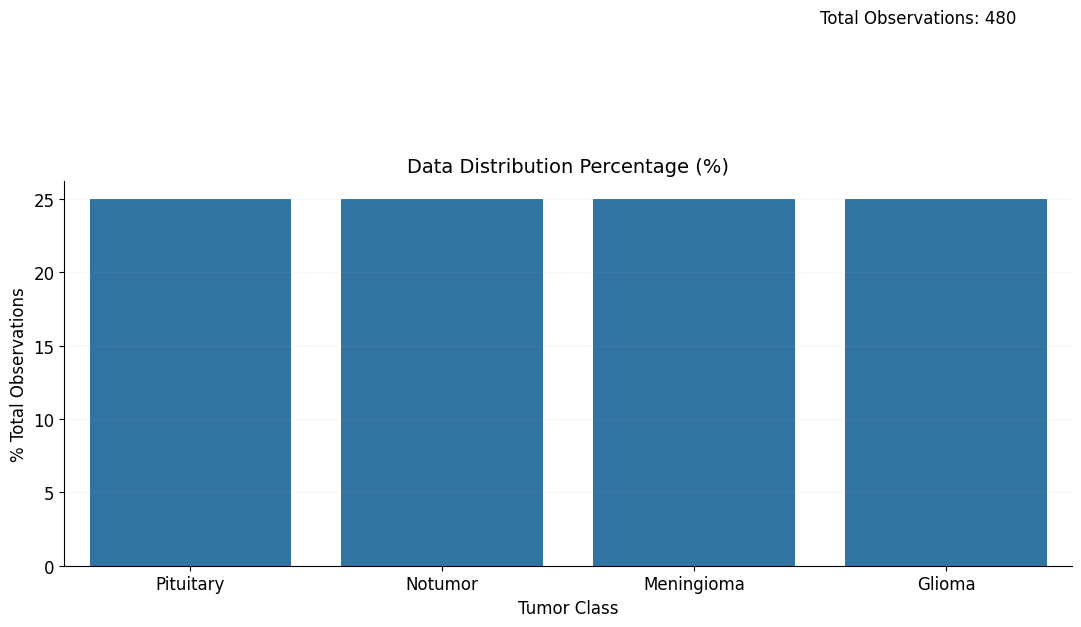

In [6]:
fig, axis = plt.subplots(figsize=(13, 5))
axis.grid(True, alpha=0.1)
axis.set_title("Data Distribution Percentage (%)", fontsize=14)
sns.barplot(x=['\n'.join(curr_index.strip().split('_')).title() for curr_index in data_distribution_count.index],
            y=100 * data_distribution_count / data_distribution_count.sum(), ax=axis)
axis.set_xlabel("Tumor Class", fontsize=12)
axis.set_ylabel("% Total Observations", fontsize=12)
axis.tick_params(which='major', labelsize=12)
axis.text(2.5, 37, f'Total Observations: {data_distribution_count.sum()}', fontdict=dict(size=12))
sns.despine()

# Split data

Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


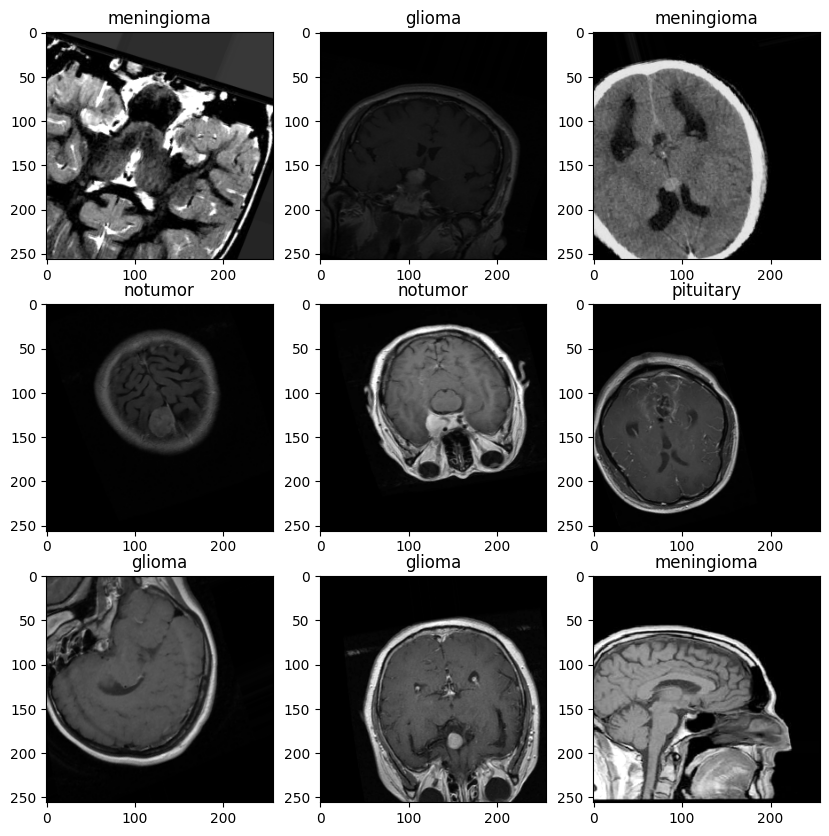

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

classes = os.listdir(dir)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range = [0.3, 1.5],
    fill_mode='nearest',
    validation_split=0.2)

validation_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    dir,
    target_size=(256, 256),
    batch_size=32,
    seed=42,
    subset='training'
)

test_generator = train_datagen.flow_from_directory(
    dir,
    target_size=(256, 256),
    batch_size=32,
    seed=42,
    subset='validation')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(256, 256),
    seed=42,
    batch_size=32
)

print(test_generator.class_indices)

# Display 1 image using matplotlib
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        # Print Class
        plt.title(classes[np.argmax(Y_batch[0])])

        plt.imshow(image)
        break



# Functions to train model

In [8]:
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import plot_model
import matplotlib.pyplot as plt

# Define the model creation function
def create_model(input_shape, num_classes):
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the initial layers
    # for layer in base_model.layers[:-10]:
    #     layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define the model training function
def train_model(model, train_generator, validation_generator, model_name):
    checkpoint = ModelCheckpoint(model_file, monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)

    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_data=test_generator,
        validation_steps=test_generator.samples // test_generator.batch_size,
        epochs=50,
        callbacks=[checkpoint, early_stopping, reduce_lr]
    )

    # # Fine-tuning: Unfreeze more layers in the base model
    # for layer in model.layers[-50:]:
    #     layer.trainable = True

    # # Recompile the model with a lower learning rate
    # model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

    # # Train the model again with fine-tuning
    # history_fine = model.fit(
    #     train_generator,
    #     steps_per_epoch=train_generator.samples // train_generator.batch_size,
    #     validation_data=validation_generator,
    #     validation_steps=validation_generator.samples // validation_generator.batch_size,
    #     epochs=50,
    #     callbacks=[checkpoint, early_stopping, reduce_lr]
    # )

    model.save(model_name)
    return model, history

# Create/Load model

In [9]:
# Check if the model exists, else create and train it
if os.path.exists(model_file):
    model = load_model(model_file)
else:
    model = create_model((256, 256, 3), len(classes))

# Plot the model architecture
plot_model(model, to_file='resnet50_model.png', show_shapes=True, show_layer_names=True)
model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                         

In [10]:
model, history = train_model(model, train_generator, validation_generator, model_file)

Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 2.0538 - accuracy: 0.3828
Epoch 1: val_loss improved from inf to 98.27734, saving model to resnet50_brain_mri.keras
12/12 [==============================] - 59s 1s/step - loss: 2.0538 - accuracy: 0.3828 - val_loss: 98.2773 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 2/50
12/12 [==============================] - ETA: 0s - loss: 1.2326 - accuracy: 0.5990
Epoch 2: val_loss did not improve from 98.27734
12/12 [==============================] - 15s 1s/step - loss: 1.2326 - accuracy: 0.5990 - val_loss: 240.7371 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 3/50
12/12 [==============================] - ETA: 0s - loss: 0.9608 - accuracy: 0.6328
Epoch 3: val_loss improved from 98.27734 to 86.23767, saving model to resnet50_brain_mri.keras
12/12 [==============================] - 14s 1s/step - loss: 0.9608 - accuracy: 0.6328 - val_loss: 86.2377 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 4/50
12/12 [==============================] - ETA

# Testing the model

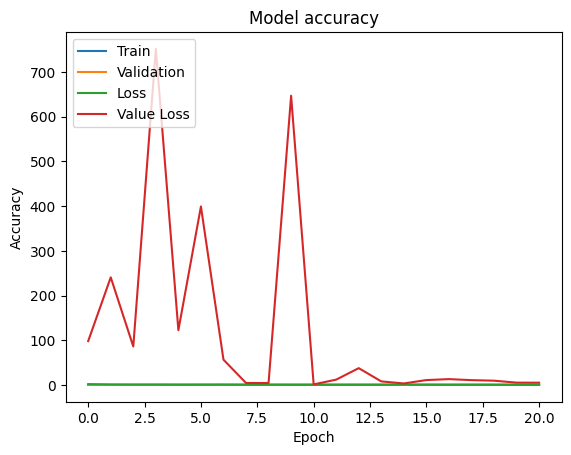

In [11]:
# Learning curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation','Loss', 'Value Loss'], loc='upper left')
plt.show()

# Validate with external test data

41/41 [==============================] - 6s 130ms/step


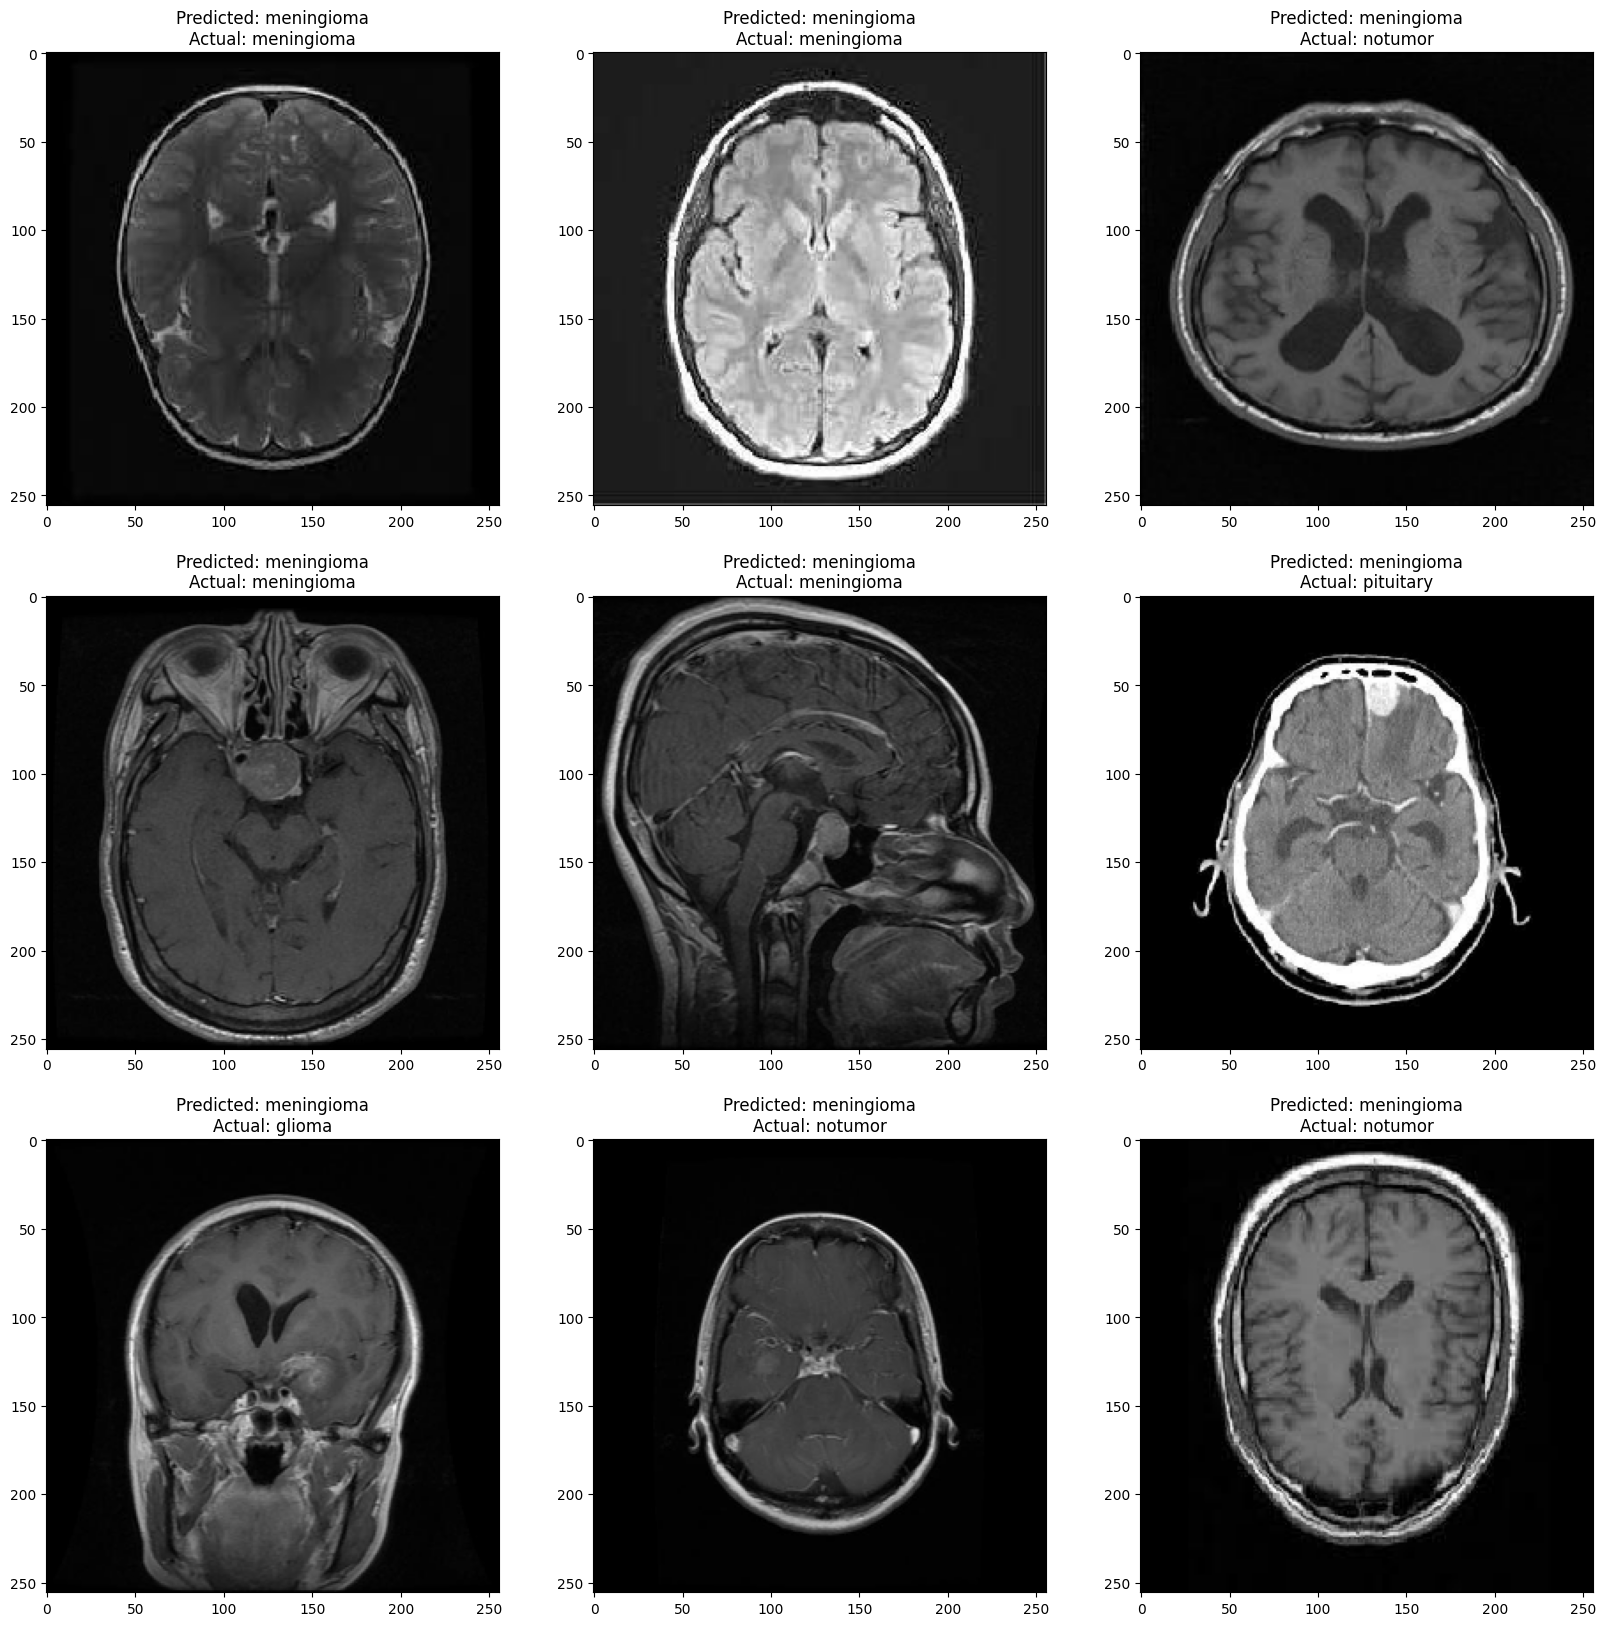

In [14]:
# Validate the model with test data

model = keras.models.load_model(model_file)
model.evaluate(validation_generator)

# Predict the output
predictions = model.predict(validation_generator)
predictions = np.argmax(predictions, axis=1)

# Predict and Display image using matplotlib
plt.figure(figsize=(20, 20))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    for X_batch, Y_batch in validation_generator:
        image = X_batch[0]
        # Print Class
        plt.title("Predicted: " + classes[predictions[i]] + "\nActual: " + classes[np.argmax(Y_batch[i])])

        plt.imshow(image)
        break


# Model visualization(Evaluation)

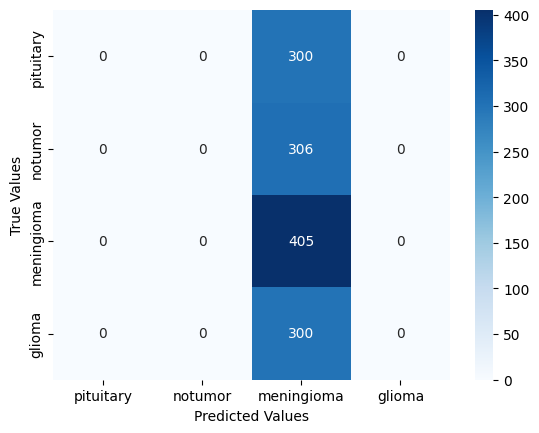

In [13]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(validation_generator.classes, predictions)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
